In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    cross_val_predict
)
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    f1_score,
    average_precision_score,
    precision_recall_curve,
    accuracy_score,
    confusion_matrix,
    recall_score
)
import sklearn.neighbors._base
from scipy.stats import randint
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import sys

sys.modules["sklearn.neighbors.base"] = sklearn.neighbors._base
from missingpy import MissForest

pd.set_option("future.no_silent_downcasting", True)
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=FutureWarning)


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
from scipy.stats import randint

In [2]:
def CG_equation(age, weight, female, serum_creatinine):
    """Cockcroft-Gault Equation."""
    constant = 0.85 if female else 1.0
    return ((140 - age) * weight * constant) / (72 * serum_creatinine)

## Data Curation

In [ ]:
# Load data
survival_df = pd.read_excel(
    "/home/sunx/data/aiiih/projects/sunx/projects/ICD_sex_diff/df.xlsx",
)
survival_df["PE_Time"] = survival_df.apply(
    lambda row: (
        row["Time from ICD Implant to Primary Endpoint (in days)"]
        if row["Was Primary Endpoint Reached? (Appropriate ICD Therapy)"] == 1
        else row["Time from ICD Implant to Last Cardiology Encounter (in days)"]
    ),
    axis=1,
)
survival_df["SE_Time"] = survival_df.apply(
    lambda row: (
        row["Time from ICD Implant to Secondary Endpoint (in days)"]
        if row["Was Secondary Endpoint Reached?"] == 1
        else row["Time from ICD Implant to Last Cardiology Encounter (in days)"]
    ),
    axis=1,
)
survival_df = survival_df[
    [
        "MRN",
        "Was Primary Endpoint Reached? (Appropriate ICD Therapy)",
        "PE_Time",
        "Was Secondary Endpoint Reached?",
        "SE_Time",
    ]
]
with_icd = pd.read_excel(
    "/home/sunx/data/aiiih/projects/sunx/projects/ICD_sex_diff/NICM Arrhythmia Cohort for Xiaotan Final.xlsx",
    sheet_name="ICD",
)
with_icd["ICD"] = 1
without_icd = pd.read_excel(
    "/home/sunx/data/aiiih/projects/sunx/projects/ICD_sex_diff/NICM Arrhythmia Cohort for Xiaotan Final.xlsx",
    sheet_name="No_ICD",
)
without_icd["ICD"] = 0
without_icd["Cockcroft-Gault Creatinine Clearance (mL/min)"] = without_icd.apply(
    lambda row: CG_equation(
        row["Age at CMR"],
        row["Weight (Kg)"],
        row["Female"],
        row["Serum creatinine (within 3 months of MRI)"],
    ),
    axis=1,
)
common_cols = with_icd.columns.intersection(without_icd.columns)
df = pd.concat([with_icd[common_cols], without_icd[common_cols]], ignore_index=True)
df.drop(
    [
        "Date VT/VF/SCD",
        "End follow-up date",
        "CRT Date",
        "QRS",
    ],
    axis=1,
    inplace=True,
)
master_spreadsheet = pd.read_excel(
    "/home/sunx/data/aiiih/projects/sunx/projects/ICD_sex_diff/survival_df.xlsx",
    sheet_name="MasterSpreadsheet",
)
master_spreadsheet = master_spreadsheet[["MRN", "Female", "Composite Outcome"]]

# Variables
var = df.columns.tolist()
categorical = [
    "Female",
    "DM",
    "HTN",
    "HLP",
    "AF",
    "NYHA Class",
    "Beta Blocker",
    "ACEi/ARB/ARNi",
    "Aldosterone Antagonist",
    "VT/VF/SCD",
    "AAD",
    "CRT",
    "ICD",
]
numerical = list(set(var) - set(categorical))
df[categorical] = df[categorical].astype("object")

# Labels
labels = ["MRN", "Female", "VT/VF/SCD", "ICD"]
features = [c for c in var if c not in labels]

# Missing percentage
missing_pct = df.isnull().sum() / len(df) * 100
print(missing_pct)


def impute_misforest(X, random_seed):
    """
    Non-parametric iterative imputation method based on random forest.
    """
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    imputer = MissForest(random_state=random_seed)
    X_imputed_scaled = pd.DataFrame(
        imputer.fit_transform(X_scaled), columns=X.columns, index=X.index
    )
    X_imputed_unscaled = pd.DataFrame(
        scaler.inverse_transform(X_imputed_scaled), columns=X.columns, index=X.index
    )
    return X_imputed_unscaled


def conversion_and_imputation(df, features, labels):
    df = df.copy()
    df = df[features + labels]

    # Convert multiclass categorical variables to numerical format
    ordinal = "NYHA Class"
    le = LabelEncoder()
    df[ordinal] = le.fit_transform(df[ordinal])

    # Convert binary columns to int
    binary_cols = [
        "Female",
        "DM",
        "HTN",
        "HLP",
        "AF",
        "Beta Blocker",
        "ACEi/ARB/ARNi",
        "Aldosterone Antagonist",
        "VT/VF/SCD",
        "AAD",
        "CRT",
        "ICD",
    ]
    exist_bin = [col for col in binary_cols if col in df.columns]
    for c in exist_bin:
        if df[c].dtype == "object":
            df[c] = df[c].replace(
                {"Yes": 1, "No": 0, "Y": 1, "N": 0, "True": 1, "False": 0}
            )
        df[c] = df[c].astype("float")

    # Imputation
    X = df[features]
    imputed_X = impute_misforest(X, 0)
    imputed_X.index = df.index
    imputed_X["MRN"] = df["MRN"].values
    imputed_X["Female"] = df["Female"].values
    imputed_X["VT/VF/SCD"] = df["VT/VF/SCD"].values
    imputed_X["ICD"] = df["ICD"].values

    # Map to 0 and 1 using 0.5 as threshold
    for c in exist_bin:
        imputed_X[c] = (imputed_X[c] >= 0.5).astype("float")

    return imputed_X


clean_df = conversion_and_imputation(df, features, labels)

# Additional
clean_df["Age by decade"] = df["Age at CMR"] // 10
clean_df["CrCl>45"] = (
    clean_df["Cockcroft-Gault Creatinine Clearance (mL/min)"] > 45
).astype(int)
clean_df["NYHA>2"] = (clean_df["NYHA Class"] > 2).astype(int)
clean_df["Significant LGE"] = (clean_df["LGE Burden 5SD"] > 2).astype(int)

# Distribution of sex
print("\nDistribution of Sex")
print(clean_df["Female"].value_counts())

# Distribution of true label
print("\nDistribution of Arrhythmia")
print(clean_df["VT/VF/SCD"].value_counts())

# Proportion in ICD population that follows the rule-based guideline
icd_df = clean_df[clean_df["ICD"] == 1]
cond = (icd_df["NYHA Class"] >= 2) & (icd_df["LVEF"] <= 35)
pct = cond.sum() / len(icd_df) * 100
print(
    f"\nProportion in ICD population that follows the rule-based guideline: {pct:.2f}%"
)

MRN                                               0.000000
Female                                            0.000000
Age at CMR                                        0.000000
BMI                                               0.000000
DM                                                0.000000
HTN                                               0.000000
HLP                                               0.000000
AF                                                0.000000
NYHA Class                                       13.434728
LVEDVi                                            0.506971
LVEF                                              0.000000
LV Mass Index                                     4.942966
RVEDVi                                            6.210393
RVEF                                              2.661597
LA EF                                            20.278834
LAVi                                             20.278834
LGE Burden 5SD                                    0.5069

### Split into train/test

In [4]:
from sklearn.model_selection import train_test_split

df = clean_df.copy()
stratify_column = df['Female'].astype(str) + '_' + df['VT/VF/SCD'].astype(str)

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=stratify_column,
    random_state=100
)

print("Overall Female proportion:", df['Female'].mean())
print("Train Female proportion:", train_df['Female'].mean())
print("Test Female proportion:", test_df['Female'].mean())

print("Overall VT proportion:", df['VT/VF/SCD'].mean())
print("Train VT proportion:", train_df['VT/VF/SCD'].mean())
print("Test VT proportion:", test_df['VT/VF/SCD'].mean())

Overall Female proportion: 0.39543726235741444
Train Female proportion: 0.39461172741679873
Test Female proportion: 0.3987341772151899
Overall VT proportion: 0.09125475285171103
Train VT proportion: 0.0919175911251981
Test VT proportion: 0.08860759493670886


## Model Comparison

In [5]:
def find_best_threshold(y_true, y_scores):
    """Find the probability threshold that maximizes the F1 score."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)
    best_idx = np.nanargmax(f1_scores[:-1])
    return thresholds[best_idx]


def compute_sensitivity_specificity(y_true, y_pred):
    """Compute sensitivity and specificity from binary predictions."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    return sensitivity, specificity


def incidence_rate(df, pred_col, label_col):
    """Compute incidence rate for males and females."""
    def rate(sub):
        n_pred = (sub[pred_col] == 1).sum()
        n_true = (sub[label_col] == 1).sum()
        return n_true / n_pred if n_pred > 0 else np.nan

    male_rate = rate(df[df["Female"] == 0])
    female_rate = rate(df[df["Female"] == 1])
    return male_rate, female_rate


def rf_evaluate(X_train, y_train_df, X_test, y_test_df, feat_names, random_state=None, visualize_importance=False):
    """Train RandomForest with randomized search and return predictions.

    Uses out-of-fold predictions on the training set to select a robust
    probability threshold (maximizing F1) without leaking test labels.
    """
    y_train = y_train_df["VT/VF/SCD"]
    y_test = y_test_df["VT/VF/SCD"]
    
    # Hyperparameter search
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    param_dist = {
        "n_estimators": randint(100, 500),
        "max_depth": [None] + list(range(5, 26, 5)),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 5),
        "max_features": ["sqrt", "log2", None],
    }
    
    base_clf = RandomForestClassifier(
        random_state=random_state, n_jobs=-1, class_weight="balanced"
    )
    ap_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    search = RandomizedSearchCV(
        estimator=base_clf,
        param_distributions=param_dist,
        n_iter=50,
        scoring=ap_scorer,
        cv=cv,
        random_state=random_state,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        search.fit(X_train, y_train)
    
    # Best hyperparameters
    best_params = search.best_params_
    
    # Determine threshold using OOF probabilities on the training set
    oof_proba = np.zeros(len(y_train), dtype=float)
    for tr_idx, val_idx in cv.split(X_train, y_train):
        oof_model = RandomForestClassifier(
            **best_params, random_state=random_state, n_jobs=-1, class_weight="balanced"
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            oof_model.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
        oof_proba[val_idx] = oof_model.predict_proba(X_train.iloc[val_idx])[:, 1]
    threshold = find_best_threshold(y_train.values, oof_proba)
    
    # Fit final model on the full training data
    final_model = RandomForestClassifier(
        **best_params, random_state=random_state, n_jobs=-1, class_weight="balanced"
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        final_model.fit(X_train, y_train)
    
    # Feature importance visualization
    if visualize_importance:
        importances = final_model.feature_importances_
        idx = np.argsort(importances)[::-1]
        highlight = {"LVEF", "NYHA"}
        colors = ["red" if feat_names[i] in highlight else "lightgray" for i in idx]
        
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(feat_names)), importances[idx], color=colors)
        plt.xticks(range(len(feat_names)), [feat_names[i] for i in idx], rotation=90)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title("Feature Importances")
        plt.tight_layout()
        plt.show()
    
    # Predict on test set
    y_prob = final_model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    
    return y_pred, y_prob


def evaluate_model_performance(y_true, y_pred, y_prob, mask_m, mask_f, overall_mask=None):
    """Evaluate model performance for overall, male, and female subsets.

    If overall_mask is provided, overall metrics are computed using only the
    entries where overall_mask is True.
    """
    # Overall performance (optionally on a subset)
    if overall_mask is None:
        y_true_overall = y_true
        y_pred_overall = y_pred
        y_prob_overall = y_prob
    else:
        y_true_overall = y_true[overall_mask]
        y_pred_overall = y_pred[overall_mask]
        y_prob_overall = y_prob[overall_mask]
    
    acc = accuracy_score(y_true_overall, y_pred_overall)
    auc = roc_auc_score(y_true_overall, y_prob_overall) if len(np.unique(y_true_overall)) > 1 else np.nan
    f1 = f1_score(y_true_overall, y_pred_overall)
    sens, spec = compute_sensitivity_specificity(y_true_overall, y_pred_overall)
    
    # Male subset
    y_true_m = y_true[mask_m]
    y_pred_m = y_pred[mask_m]
    y_prob_m = y_prob[mask_m]
    
    male_acc = accuracy_score(y_true_m, y_pred_m) if len(y_true_m) > 0 else np.nan
    male_auc = roc_auc_score(y_true_m, y_prob_m) if len(y_true_m) > 1 and len(np.unique(y_true_m)) > 1 else np.nan
    male_f1 = f1_score(y_true_m, y_pred_m) if len(y_true_m) > 0 else np.nan
    male_sens, male_spec = compute_sensitivity_specificity(y_true_m, y_pred_m) if len(y_true_m) > 0 else (np.nan, np.nan)
    
    # Female subset
    y_true_f = y_true[mask_f]
    y_pred_f = y_pred[mask_f]
    y_prob_f = y_prob[mask_f]
    
    female_acc = accuracy_score(y_true_f, y_pred_f) if len(y_true_f) > 0 else np.nan
    female_auc = roc_auc_score(y_true_f, y_prob_f) if len(y_true_f) > 1 and len(np.unique(y_true_f)) > 1 else np.nan
    female_f1 = f1_score(y_true_f, y_pred_f) if len(y_true_f) > 0 else np.nan
    female_sens, female_spec = compute_sensitivity_specificity(y_true_f, y_pred_f) if len(y_true_f) > 0 else (np.nan, np.nan)
    
    return {
        'accuracy': acc, 'auc': auc, 'f1': f1, 'sensitivity': sens, 'specificity': spec,
        'male_accuracy': male_acc, 'male_auc': male_auc, 'male_f1': male_f1, 
        'male_sensitivity': male_sens, 'male_specificity': male_spec,
        'female_accuracy': female_acc, 'female_auc': female_auc, 'female_f1': female_f1,
        'female_sensitivity': female_sens, 'female_specificity': female_spec
    }


def create_undersampled_dataset(train_df, label_col, random_state):
    """Create balanced dataset using undersampling."""
    n_male = (train_df["Female"] == 0).sum()
    n_female = (train_df["Female"] == 1).sum()
    n_target = ceil((n_male + n_female) / 2)
    
    sampled_parts = []
    for sex_val in (0, 1):
        grp = train_df[train_df["Female"] == sex_val]
        pos = grp[grp[label_col] == 1]
        neg = grp[grp[label_col] == 0]
        
        pos_n_target = int(round(len(pos) / len(grp) * n_target))
        neg_n_target = n_target - pos_n_target
        
        replace_pos = pos_n_target > len(pos)
        replace_neg = neg_n_target > len(neg)
        
        samp_pos = pos.sample(n=pos_n_target, replace=replace_pos, random_state=random_state)
        samp_neg = neg.sample(n=neg_n_target, replace=replace_neg, random_state=random_state)
        
        sampled_parts.append(pd.concat([samp_pos, samp_neg]))
    
    return pd.concat(sampled_parts).sample(frac=1, random_state=random_state).reset_index(drop=True)


def run_guideline_model(X_test, y_test, label_col):
    """Run guideline-based model using NYHA Class and LVEF."""
    pred = ((X_test["NYHA Class"] >= 2) & (X_test["LVEF"] <= 35)).astype(int).values
    y_true = y_test[label_col].values
    
    # Create evaluation dataframe for incidence rate calculation
    eval_df = y_test.reset_index(drop=True).copy()
    eval_df["pred"] = pred
    m_rate, f_rate = incidence_rate(eval_df, "pred", label_col)
    
    return pred, np.full_like(pred, 0.5, dtype=float), m_rate, f_rate


def run_sex_specific_models(train_m, train_f, test_m, test_f, features, label_col, random_state):
    """Train and evaluate sex-specific models."""
    results = {}
    
    # Train male model
    if not train_m.empty and not test_m.empty:
        pred_m, prob_m = rf_evaluate(
            train_m[features], train_m[[label_col, "Female"]], 
            test_m[features], test_m[[label_col, "Female"]], 
            features, random_state
        )
        results['male'] = {'pred': pred_m, 'prob': prob_m}
    
    # Train female model
    if not train_f.empty and not test_f.empty:
        pred_f, prob_f = rf_evaluate(
            train_f[features], train_f[[label_col, "Female"]], 
            test_f[features], test_f[[label_col, "Female"]], 
            features, random_state
        )
        results['female'] = {'pred': pred_f, 'prob': prob_f}
    
    return results


def multiple_random_splits_simplified(df, N, label="VT/VF/SCD"):
    """Simplified version of multiple random splits evaluation."""
    
    # Feature definitions
    feature_sets = {
        'guideline': ["NYHA Class", "LVEF"],
        'benchmark': ["Female", "Age by decade", "BMI", "AF", "Beta Blocker", "CrCl>45", 
                     "LVEF", "QTc", "NYHA>2", "CRT", "AAD", "Significant LGE"],
        'proposed': ["Female", "Age by decade", "BMI", "AF", "Beta Blocker", "CrCl>45", 
                    "LVEF", "QTc", "NYHA>2", "CRT", "AAD", "Significant LGE", "DM", "HTN", 
                    "HLP", "LVEDVi", "LV Mass Index", "RVEDVi", "RVEF", "LA EF", "LAVi", 
                    "MRF (%)", "Sphericity Index", "Relative Wall Thickness", 
                    "MV Annular Diameter", "ACEi/ARB/ARNi", "Aldosterone Antagonist"],
        'real_proposed': ["Female", "Age by decade", "BMI", "AF", "Beta Blocker", "CrCl>45", 
                         "LVEF", "QTc", "CRT", "AAD", "LGE Burden 5SD", "DM", "HTN", 
                         "HLP", "LVEDVi", "LV Mass Index", "RVEDVi", "RVEF", "LA EF", "LAVi", 
                         "MRF (%)", "Sphericity Index", "Relative Wall Thickness", 
                         "MV Annular Diameter", "ACEi/ARB/ARNi", "Aldosterone Antagonist", "NYHA Class"]
    }
    
    # Model configurations - now with all 17 models
    model_configs = [
        {'name': 'Guideline', 'features': 'guideline', 'type': 'rule_based'},
        {'name': 'RF Guideline', 'features': 'guideline', 'type': 'ml'},
        {'name': 'Benchmark Sex-agnostic', 'features': 'benchmark', 'type': 'ml'},
        {'name': 'Benchmark Sex-agnostic (undersampled)', 'features': 'benchmark', 'type': 'ml_undersampled'},
        {'name': 'Benchmark Male', 'features': 'benchmark', 'type': 'male_only'},
        {'name': 'Benchmark Female', 'features': 'benchmark', 'type': 'female_only'},
        {'name': 'Benchmark Sex-specific', 'features': 'benchmark', 'type': 'sex_specific'},
        {'name': 'Proposed Sex-agnostic', 'features': 'proposed', 'type': 'ml'},
        {'name': 'Proposed Sex-agnostic (undersampled)', 'features': 'proposed', 'type': 'ml_undersampled'},
        {'name': 'Proposed Male', 'features': 'proposed', 'type': 'male_only'},
        {'name': 'Proposed Female', 'features': 'proposed', 'type': 'female_only'},
        {'name': 'Proposed Sex-specific', 'features': 'proposed', 'type': 'sex_specific'},
        {'name': 'Real Proposed Sex-agnostic', 'features': 'real_proposed', 'type': 'ml'},
        {'name': 'Real Proposed Sex-agnostic (undersampled)', 'features': 'real_proposed', 'type': 'ml_undersampled'},
        {'name': 'Real Proposed Male', 'features': 'real_proposed', 'type': 'male_only'},
        {'name': 'Real Proposed Female', 'features': 'real_proposed', 'type': 'female_only'},
        {'name': 'Real Proposed Sex-specific', 'features': 'real_proposed', 'type': 'sex_specific'}
    ]
    
    # Metrics to track
    metrics = ['accuracy', 'auc', 'f1', 'sensitivity', 'specificity', 
               'male_accuracy', 'male_auc', 'male_f1', 'male_sensitivity', 'male_specificity',
               'female_accuracy', 'female_auc', 'female_f1', 'female_sensitivity', 'female_specificity',
               'male_rate', 'female_rate']
    
    # Initialize results storage
    results = {config['name']: {met: [] for met in metrics} for config in model_configs}
    
    for seed in range(N):
        print(f"Running split #{seed+1}")
        
        # Split data
        train_df, test_df = train_test_split(df, test_size=0.3, random_state=seed, stratify=df[label])
        tr_m = train_df[train_df["Female"] == 0]
        tr_f = train_df[train_df["Female"] == 1]
        te_m = test_df[test_df["Female"] == 0]
        te_f = test_df[test_df["Female"] == 1]
        
        # Create undersampled dataset
        us_train_df = create_undersampled_dataset(train_df, label, seed)
        
        # Create masks for gender subsets
        mask_m = test_df["Female"].values == 0
        mask_f = test_df["Female"].values == 1
        y_true = test_df[label].values
        
        # Evaluate each model configuration
        for config in model_configs:
            model_name = config['name']
            feature_set = feature_sets[config['features']]
            model_type = config['type']
            
            # Default: evaluate overall on full test and use true male/female masks
            mask_m_eval = mask_m
            mask_f_eval = mask_f
            overall_mask_override = None
            
            if model_type == 'rule_based':
                # Guideline model
                pred, prob, m_rate, f_rate = run_guideline_model(
                    test_df[feature_set], test_df[[label, "Female"]], label
                )
                
            elif model_type == 'ml':
                # Standard ML model
                pred, prob = rf_evaluate(
                    train_df[feature_set], train_df[[label, "Female"]],
                    test_df[feature_set], test_df[[label, "Female"]],
                    feature_set, seed
                )
                eval_df = test_df[[label, "Female"]].reset_index(drop=True).copy()
                eval_df["pred"] = pred
                m_rate, f_rate = incidence_rate(eval_df, "pred", label)
                
            elif model_type == 'ml_undersampled':
                # Undersampled ML model
                pred, prob = rf_evaluate(
                    us_train_df[feature_set], us_train_df[[label, "Female"]],
                    test_df[feature_set], test_df[[label, "Female"]],
                    feature_set, seed
                )
                eval_df = test_df[[label, "Female"]].reset_index(drop=True).copy()
                eval_df["pred"] = pred
                m_rate, f_rate = incidence_rate(eval_df, "pred", label)
                
            elif model_type == 'male_only':
                # Male-only model
                if not tr_m.empty and not te_m.empty:
                    pred, prob = rf_evaluate(
                        tr_m[feature_set], tr_m[[label, "Female"]],
                        te_m[feature_set], te_m[[label, "Female"]],
                        feature_set, seed
                    )
                    # Create full test set predictions (only male predictions)
                    full_pred = np.zeros(len(test_df), dtype=int)
                    full_prob = np.zeros(len(test_df), dtype=float)
                    full_pred[mask_m] = pred
                    full_prob[mask_m] = prob
                    pred, prob = full_pred, full_prob
                    eval_df = test_df[[label, "Female"]].reset_index(drop=True).copy()
                    eval_df["pred"] = pred
                    m_rate, f_rate = incidence_rate(eval_df, "pred", label)
                    # Evaluate overall metrics only on the male subset
                    mask_f_eval = np.zeros_like(mask_f, dtype=bool)
                    overall_mask_override = mask_m
                else:
                    # Handle case with no male data
                    pred = np.zeros(len(test_df), dtype=int)
                    prob = np.zeros(len(test_df), dtype=float)
                    m_rate, f_rate = 0.0, 0.0
                    mask_f_eval = np.zeros_like(mask_f, dtype=bool)
                    overall_mask_override = mask_m
                
            elif model_type == 'female_only':
                # Female-only model
                if not tr_f.empty and not te_f.empty:
                    pred, prob = rf_evaluate(
                        tr_f[feature_set], tr_f[[label, "Female"]],
                        te_f[feature_set], te_f[[label, "Female"]],
                        feature_set, seed
                    )
                    # Create full test set predictions (only female predictions)
                    full_pred = np.zeros(len(test_df), dtype=int)
                    full_prob = np.zeros(len(test_df), dtype=float)
                    full_pred[mask_f] = pred
                    full_prob[mask_f] = prob
                    pred, prob = full_pred, full_prob
                    eval_df = test_df[[label, "Female"]].reset_index(drop=True).copy()
                    eval_df["pred"] = pred
                    m_rate, f_rate = incidence_rate(eval_df, "pred", label)
                    # Evaluate overall metrics only on the female subset
                    mask_m_eval = np.zeros_like(mask_m, dtype=bool)
                    overall_mask_override = mask_f
                else:
                    # Handle case with no female data
                    pred = np.zeros(len(test_df), dtype=int)
                    prob = np.zeros(len(test_df), dtype=float)
                    m_rate, f_rate = 0.0, 0.0
                    mask_m_eval = np.zeros_like(mask_m, dtype=bool)
                    overall_mask_override = mask_f
                
            elif model_type == 'sex_specific':
                # Sex-specific models
                sex_results = run_sex_specific_models(
                    tr_m, tr_f, te_m, te_f, feature_set, label, seed
                )
                
                # Combine predictions
                combined_pred = np.empty(len(test_df), dtype=int)
                combined_prob = np.empty(len(test_df), dtype=float)
                
                if 'male' in sex_results:
                    combined_pred[mask_m] = sex_results['male']['pred']
                    combined_prob[mask_m] = sex_results['male']['prob']
                if 'female' in sex_results:
                    combined_pred[mask_f] = sex_results['female']['pred']
                    combined_prob[mask_f] = sex_results['female']['prob']
                
                pred, prob = combined_pred, combined_prob
                eval_df = test_df[[label, "Female"]].reset_index(drop=True).copy()
                eval_df["pred"] = pred
                m_rate, f_rate = incidence_rate(eval_df, "pred", label)
            
            # Evaluate performance
            perf_metrics = evaluate_model_performance(y_true, pred, prob, mask_m_eval, mask_f_eval, overall_mask=overall_mask_override)
            
            # Store results
            for metric, value in perf_metrics.items():
                results[model_name][metric].append(value)
            
            # Store incidence rates
            results[model_name]['male_rate'].append(m_rate)
            results[model_name]['female_rate'].append(f_rate)
    
    # Compute summary statistics
    summary = {}
    for model, metrics_dict in results.items():
        summary[model] = {}
        for metric, values in metrics_dict.items():
            arr = np.array(values, dtype=float)
            mu = np.nanmean(arr)
            se = np.nanstd(arr, ddof=1) / np.sqrt(np.sum(~np.isnan(arr)))
            ci = 1.96 * se
            summary[model][metric] = (mu, mu - ci, mu + ci)
    
    # Create summary DataFrame
    summary_df = pd.concat(
        {
            model: pd.DataFrame.from_dict(
                metrics_dict, orient="index", columns=["mean", "ci_lower", "ci_upper"]
            )
            for model, metrics_dict in summary.items()
        },
        axis=0,
    )
    
    # Format summary table
    formatted = summary_df.apply(
        lambda row: f"{row['mean']:.3f} ({row['ci_lower']:.3f}, {row['ci_upper']:.3f})",
        axis=1,
    )
    summary_table = formatted.unstack(level=1)
    
    return results, summary_table

In [6]:
res, summary = multiple_random_splits_simplified(train_df, 50)
print(summary)

Running split #1


Running split #2
Running split #3
Running split #4
Running split #5
Running split #6
Running split #7
Running split #8
Running split #9
Running split #10
Running split #11
Running split #12
Running split #13
Running split #14
Running split #15
Running split #16
Running split #17
Running split #18
Running split #19
Running split #20
Running split #21
Running split #22
Running split #23
Running split #24
Running split #25
Running split #26
Running split #27
Running split #28
Running split #29
Running split #30
Running split #31
Running split #32
Running split #33
Running split #34
Running split #35
Running split #36
Running split #37
Running split #38
Running split #39
Running split #40
Running split #41
Running split #42
Running split #43
Running split #44
Running split #45
Running split #46
Running split #47
Running split #48
Running split #49
Running split #50
                                                       accuracy  \
Guideline                                  0.446 (0.438, 0.

/tmp/ipykernel_3978179/1881788207.py:431: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(arr)
/data/aiiih/envs/sunx1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [7]:
summary.to_excel('/home/sunx/data/aiiih/projects/sunx/projects/ICD_sex_diff/results.xlsx', index=True, index_label='RowName')

## Inference

In [12]:
def train_sex_specific_model(X_train, y_train, features, seed):
    """
    Train a sex-specific model using cross-validation for threshold determination.
    """
    # RF params
    param_dist = {
        "n_estimators": randint(100, 500),
        "max_depth": [None] + list(range(5, 26, 5)),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 5),
        "max_features": ["sqrt", "log2", None],
    }
    
    base_clf = RandomForestClassifier(
        random_state=seed, n_jobs=-1, class_weight="balanced"
    )
    ap_scorer = make_scorer(average_precision_score, needs_proba=True)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    search = RandomizedSearchCV(
        estimator=base_clf,
        param_distributions=param_dist,
        n_iter=50,
        scoring=ap_scorer,
        cv=cv,
        random_state=seed,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )
    
    # Train model
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    print("Best hyperparameters:", search.best_params_)
    
    # Use cross-validation to determine threshold
    cv_probs = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    best_threshold = find_best_threshold(y_train, cv_probs)
    
    return best_model, best_threshold


def plot_feature_importances(model, features, title, seed):
    """Plot feature importances with consistent styling."""
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1]
    sorted_features = [features[i] for i in idx]
    
    colors = [
        "red" if f in {"LVEF", "NYHA Class", "NYHA>2"}
        else "gold" if f in {"Significant LGE", "LGE Burden 5SD"} 
        else "lightgray"
        for f in sorted_features
    ]
    
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(sorted_features)), importances[idx], color=colors)
    plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()





def perform_clustering_analysis(X_test, prob_values, gender, seed, max_clusters=10):
    """Perform clustering analysis for a specific gender and return cluster risk scores."""
    if X_test.empty:
        return None, None
    
    # Elbow method
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=seed)
        kmeans.fit(X_test)
        inertias.append(kmeans.inertia_)
    
    diffs = np.diff(inertias)
    diff_ratios = diffs / inertias[:-1]
    best_k = np.argmin(diff_ratios) + 1
    if best_k < 2:
        best_k = 2
    
    print(f"Selected best number of clusters for {gender} using elbow method: {best_k}")
    
    # Final clustering
    kmeans = KMeans(n_clusters=best_k, random_state=seed)
    cluster_labels = kmeans.fit_predict(X_test)
    
    # Calculate average risk per cluster
    cluster_risk = pd.Series(prob_values, index=range(len(prob_values))).groupby(cluster_labels).mean().round(3)
    print(f"Average risk per cluster ({gender}):")
    print(cluster_risk)
    
    return cluster_labels, cluster_risk


def bootstrap_evaluation(df, features, labels, male_model, female_model, 
                        male_threshold, female_threshold, seed, B=100):
    """Perform bootstrap evaluation for both models."""
    metrics = {
        'male': {'accs': [], 'aucs': [], 'f1s': [], 'sens': [], 'spec': []},
        'female': {'accs': [], 'aucs': [], 'f1s': [], 'sens': [], 'spec': []}
    }
    
    for i in range(B):
        # Bootstrap the original data (not the predictions)
        df_boot = resample(df, replace=True, n_samples=len(df), random_state=seed + i)
        
        # Male bootstrap
        m_boot = df_boot[df_boot["Female"] == 0]
        if not m_boot.empty:
            X_m_boot = m_boot[features]
            y_m_boot = m_boot[labels]
            prob_m_boot = male_model.predict_proba(X_m_boot)[:, 1]
            pred_m_boot = (prob_m_boot >= male_threshold).astype(int)
            
            metrics['male']['accs'].append(accuracy_score(y_m_boot, pred_m_boot))
            metrics['male']['aucs'].append(roc_auc_score(y_m_boot, prob_m_boot))
            metrics['male']['f1s'].append(f1_score(y_m_boot, pred_m_boot))
            metrics['male']['sens'].append(recall_score(y_m_boot, pred_m_boot))
            metrics['male']['spec'].append(recall_score(y_m_boot, pred_m_boot, pos_label=0))
        
        # Female bootstrap
        f_boot = df_boot[df_boot["Female"] == 1]
        if not f_boot.empty:
            X_f_boot = f_boot[features]
            y_f_boot = f_boot[labels]
            prob_f_boot = female_model.predict_proba(X_f_boot)[:, 1]
            pred_f_boot = (prob_f_boot >= female_threshold).astype(int)
            
            metrics['female']['accs'].append(accuracy_score(y_f_boot, pred_f_boot))
            metrics['female']['aucs'].append(roc_auc_score(y_f_boot, prob_f_boot))
            metrics['female']['f1s'].append(f1_score(y_f_boot, pred_f_boot))
            metrics['female']['sens'].append(recall_score(y_f_boot, pred_f_boot))
            metrics['female']['spec'].append(recall_score(y_f_boot, pred_f_boot, pos_label=0))
    
    return metrics


def print_bootstrap_results(metrics, gender):
    """Print bootstrap results for a specific gender."""
    if not metrics[gender]['accs']:
        return
    
    for metric_name in ['accs', 'aucs', 'f1s', 'sens', 'spec']:
        values = metrics[gender][metric_name]
        mean_val = np.mean(values)
        ci_low = np.percentile(values, 2.5)
        ci_high = np.percentile(values, 97.5)
        metric_display = metric_name.replace('s', '').title()
        print(f"{gender.title()} {metric_display}: {mean_val:.4f} [95% CI: {ci_low:.4f} - {ci_high:.4f}]")


def plot_km_by_gender_and_risk(merged_df, gender_col, risk_col, time_col, event_col, title_prefix):
    """Plot Kaplan-Meier curves separately for each gender and risk group."""
    genders = merged_df[gender_col].unique()
    
    for gender in genders:
        gender_data = merged_df[merged_df[gender_col] == gender]
        gender_label = "Female" if gender == 1 else "Male"
        
        if gender_data.empty:
            continue
            
        # Get risk groups for this gender
        risk_groups = gender_data[risk_col].unique()
        
        if len(risk_groups) < 2:
            continue
            
        fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
        
        for ax, (ep_name, ep_time_col, ep_event_col) in zip(axes, [
            ("Primary Endpoint", "PE_Time", "Was Primary Endpoint Reached? (Appropriate ICD Therapy)"),
            ("Secondary Endpoint", "SE_Time", "Was Secondary Endpoint Reached?")
        ]):
            kmf = KaplanMeierFitter()
            
            for risk_group in sorted(risk_groups):
                mask = (gender_data[gender_col] == gender) & (gender_data[risk_col] == risk_group)
                risk_data = gender_data[mask]
                
                if risk_data.empty:
                    continue
                    
                n_risk = len(risk_data)
                events_risk = risk_data[ep_event_col].sum()
                risk_label = f"{'High' if risk_group == 1 else 'Low'} Risk (n={n_risk}, events={events_risk})"
                
                kmf.fit(
                    durations=risk_data[ep_time_col],
                    event_observed=risk_data[ep_event_col],
                    label=risk_label
                )
                kmf.plot(ax=ax)
            
            # Perform log-rank test if we have both risk groups
            if len(risk_groups) == 2:
                low_mask = (gender_data[gender_col] == gender) & (gender_data[risk_col] == 0)
                high_mask = (gender_data[gender_col] == gender) & (gender_data[risk_col] == 1)
                
                if low_mask.sum() > 0 and high_mask.sum() > 0:
                    lr = logrank_test(
                        gender_data.loc[low_mask, ep_time_col],
                        gender_data.loc[high_mask, ep_time_col],
                        gender_data.loc[low_mask, ep_event_col],
                        gender_data.loc[high_mask, ep_event_col]
                    )
                    ax.text(0.95, 0.05, f"Log-rank p = {lr.p_value:.5f}", 
                            transform=ax.transAxes, ha="right", va="bottom")
            
            ax.set_title(f"{ep_name} by Risk Group - {gender_label}")
            ax.set_xlabel("Time")
            ax.set_ylabel("Survival Probability")
            ax.legend()
        
        plt.suptitle(f"{title_prefix} - {gender_label}")
        plt.tight_layout()
        plt.show()
        plt.close()


def full_model_inference(train_df, test_df, features, labels, survival_df, seed):
    """Main function with separate male/female models and risk group analysis by ICD status."""
    import pandas as pd
    
    train = train_df.copy()
    test = test_df.copy()
    df = test.copy()

    # Separate data by gender
    train_m = train[train["Female"] == 0].copy()
    train_f = train[train["Female"] == 1].copy()
    test_m = test[test["Female"] == 0].copy()
    test_f = test[test["Female"] == 1].copy()

    # Train models and determine thresholds using cross-validation
    print("Training Male Model...")
    best_male, best_thr_m = train_sex_specific_model(
        train_m[features], train_m[labels], features, seed
    )
    
    print("Training Female Model...")
    best_female, best_thr_f = train_sex_specific_model(
        train_f[features], train_f[labels], features, seed
    )

    # Make predictions on test set using respective models
    if not test_m.empty:
        prob_m = best_male.predict_proba(test_m[features])[:, 1]
        pred_m = (prob_m >= best_thr_m).astype(int)
        df.loc[df["Female"] == 0, "pred_sexspecific"] = pred_m
        df.loc[df["Female"] == 0, "prob_sexspecific"] = prob_m
    
    if not test_f.empty:
        prob_f = best_female.predict_proba(test_f[features])[:, 1]
        pred_f = (prob_f >= best_thr_f).astype(int)
        df.loc[df["Female"] == 1, "pred_sexspecific"] = pred_f
        df.loc[df["Female"] == 1, "prob_sexspecific"] = pred_f

    # Plot feature importances
    plot_feature_importances(best_male, features, "Male Model Feature Importances", seed)
    plot_feature_importances(best_female, features, "Female Model Feature Importances", seed)

    # Merge with survival data and ICD information for risk group analysis
    pred_labels = df[["MRN", "pred_sexspecific", "ICD"]].drop_duplicates()
    merged_df = survival_df.merge(pred_labels, on="MRN", how="inner").drop_duplicates(subset=["MRN"])

    print("\n=== Risk Group Analysis by ICD Status ===")
    
    # Analyze ICD group (ICD=1) - Appropriate ICD Therapy endpoint
    icd_df = merged_df[merged_df["ICD"] == 1].copy()
    if not icd_df.empty:
        print(f"\n--- ICD Group Analysis (n={len(icd_df)}) ---")
        print("Endpoint: Appropriate ICD Therapy")
        
        # High vs Low risk comparison
        mask_low = icd_df["pred_sexspecific"] == 0
        mask_high = icd_df["pred_sexspecific"] == 1
        
        n_low = mask_low.sum()
        n_high = mask_high.sum()
        
        if n_low > 0 and n_high > 0:
            events_low = icd_df.loc[mask_low, "Was Primary Endpoint Reached? (Appropriate ICD Therapy)"].sum()
            events_high = icd_df.loc[mask_high, "Was Primary Endpoint Reached? (Appropriate ICD Therapy)"].sum()
            
            # Calculate incidence rates
            icd_low_rate = events_low / n_low if n_low > 0 else 0
            icd_high_rate = events_high / n_high if n_high > 0 else 0
            
            print(f"Low Risk Group (n={n_low}): {events_low} events, Incidence Rate: {icd_low_rate:.4f}")
            print(f"High Risk Group (n={n_high}): {events_high} events, Incidence Rate: {icd_high_rate:.4f}")
            
            # Statistical test for binary outcome
            from scipy.stats import chi2_contingency
            contingency_table = np.array([[events_low, n_low - events_low], 
                                        [events_high, n_high - events_high]])
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            print(f"Chi-square test p-value: {p_value:.5f}")
            
            # Risk ratio
            if icd_low_rate > 0:
                risk_ratio = icd_high_rate / icd_low_rate
                print(f"Risk Ratio (High/Low): {risk_ratio:.3f}")
            else:
                print("Risk Ratio: Cannot calculate (no events in low risk group)")
        else:
            print("Cannot perform analysis: insufficient samples in one or both risk groups")
    
    # Analyze No-ICD group (ICD=0) - Mortality endpoint
    no_icd_df = merged_df[merged_df["ICD"] == 0].copy()
    if not no_icd_df.empty:
        print(f"\n--- No-ICD Group Analysis (n={len(no_icd_df)}) ---")
        print("Endpoint: Mortality (Secondary Endpoint)")
        
        # High vs Low risk comparison
        mask_low = no_icd_df["pred_sexspecific"] == 0
        mask_high = no_icd_df["pred_sexspecific"] == 1
        
        n_low = mask_low.sum()
        n_high = mask_high.sum()
        
        if n_low > 0 and n_high > 0:
            events_low = no_icd_df.loc[mask_low, "Was Secondary Endpoint Reached?"].sum()
            events_high = no_icd_df.loc[mask_high, "Was Secondary Endpoint Reached?"].sum()
            
            # Calculate incidence rates
            no_icd_low_rate = events_low / n_low if n_low > 0 else 0
            no_icd_high_rate = events_high / n_high if n_high > 0 else 0
            
            print(f"Low Risk Group (n={n_low}): {events_low} events, Incidence Rate: {no_icd_low_rate:.4f}")
            print(f"High Risk Group (n={n_high}): {events_high} events, Incidence Rate: {no_icd_high_rate:.4f}")
            
            # Statistical test for binary outcome
            from scipy.stats import chi2_contingency
            contingency_table = np.array([[events_low, n_low - events_low], 
                                        [events_high, n_high - events_high]])
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            print(f"Chi-square test p-value: {p_value:.5f}")
            
            # Risk ratio
            if no_icd_low_rate > 0:
                risk_ratio = no_icd_high_rate / no_icd_low_rate
                print(f"Risk Ratio (High/Low): {risk_ratio:.3f}")
            else:
                print("Risk Ratio: Cannot calculate (no events in low risk group)")
        else:
            print("Cannot perform analysis: insufficient samples in one or both risk groups")
    
    # Overall summary
    print(f"\n=== Overall Summary ===")
    print(f"Total test samples: {len(df)}")
    print(f"ICD group: {len(merged_df[merged_df['ICD'] == 1])}")
    print(f"No-ICD group: {len(merged_df[merged_df['ICD'] == 0])}")
    
    # Risk group distribution
    risk_dist = merged_df["pred_sexspecific"].value_counts().sort_index()
    print(f"\nRisk Group Distribution:")
    for risk_level, count in risk_dist.items():
        risk_label = "Low Risk" if risk_level == 0 else "High Risk"
        print(f"  {risk_label}: {count}")

    # Clustering analysis (without visualization, only risk score comparison)
    if not test_m.empty:
        print("\nMale Clustering Analysis:")
        cluster_labels_m, cluster_risk_m = perform_clustering_analysis(
            test_m[features], prob_m, "Male", seed
        )
        if cluster_labels_m is not None:
            df.loc[df["Female"] == 0, "cluster"] = cluster_labels_m
    
    if not test_f.empty:
        print("\nFemale Clustering Analysis:")
        cluster_labels_f, cluster_risk_f = perform_clustering_analysis(
            test_f[features], prob_f, "Female", seed
        )
        if cluster_labels_f is not None:
            df.loc[df["Female"] == 1, "cluster"] = cluster_labels_f

    # Bootstrap evaluation
    print("\nPerforming Bootstrap Evaluation...")
    bootstrap_metrics = bootstrap_evaluation(
        train, features, labels, best_male, best_female, 
        best_thr_m, best_thr_f, seed
    )
    
    print("\nBootstrap Results:")
    print_bootstrap_results(bootstrap_metrics, 'male')
    print_bootstrap_results(bootstrap_metrics, 'female')

    return None


In [55]:
def rf_train_and_predict_no_test_labels(X_train, y_train_df, X_test, feat_names, random_state=None, visualize_importance=False):
    """Train RF on full training data and predict on X_test without needing test labels.

    - Uses randomized search optimizing average precision
    - Selects threshold from out-of-fold probabilities on training set
    - Fits final model on full training data and predicts probabilities on X_test
    - Returns (y_pred, y_prob, threshold)
    """
    y_train = y_train_df["VT/VF/SCD"]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    param_dist = {
        "n_estimators": randint(100, 500),
        "max_depth": [None] + list(range(5, 26, 5)),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 5),
        "max_features": ["sqrt", "log2", None],
    }

    base_clf = RandomForestClassifier(
        random_state=random_state, n_jobs=-1, class_weight="balanced"
    )
    ap_scorer = make_scorer(average_precision_score, needs_proba=True)

    search = RandomizedSearchCV(
        estimator=base_clf,
        param_distributions=param_dist,
        n_iter=50,
        scoring=ap_scorer,
        cv=cv,
        random_state=random_state,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        search.fit(X_train, y_train)

    best_params = search.best_params_

    # Determine threshold using OOF probabilities on the training set
    oof_proba = np.zeros(len(y_train), dtype=float)
    for tr_idx, val_idx in cv.split(X_train, y_train):
        oof_model = RandomForestClassifier(
            **best_params, random_state=random_state, n_jobs=-1, class_weight="balanced"
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            oof_model.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
        oof_proba[val_idx] = oof_model.predict_proba(X_train.iloc[val_idx])[:, 1]
    threshold = find_best_threshold(y_train.values, oof_proba)

    # Fit final model on the full training data
    final_model = RandomForestClassifier(
        **best_params, random_state=random_state, n_jobs=-1, class_weight="balanced"
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        final_model.fit(X_train, y_train)

    # Optional: visualize feature importance
    if visualize_importance:
        importances = final_model.feature_importances_
        idx = np.argsort(importances)[::-1]
        highlight = {"LVEF", "NYHA"}
        colors = ["red" if feat_names[i] in highlight else "lightgray" for i in idx]
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(feat_names)), importances[idx], color=colors)
        plt.xticks(range(len(feat_names)), [feat_names[i] for i in idx], rotation=90)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title("Feature Importances")
        plt.tight_layout()
        plt.show()

    # Predict on inference set
    y_prob = final_model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    return y_pred, y_prob, threshold


def build_survival_based_label(
    survival_df,
    id_col,
    icd_indicator_col,
    appropriate_icd_shock_col,
    death_col,
    output_label_col="DerivedOutcome",
    icd_source_df=None,
    master_df=None,
    master_label_col="Composite Outcome",
    master_id_col=None,
):
    """Construct binary labels for evaluation using ICD status and external master spreadsheet.

    Logic:
      - If ICD implanted (icd_indicator_col == 1): label = appropriate_icd_shock_col (from survival_df)
      - If no ICD (icd_indicator_col == 0):       label = master_df[master_label_col] by MRN join
        (falls back to death_col if master_df is not provided)
    The resulting label is binarized to {0,1}.

    If icd_source_df is provided, the ICD indicator will be taken from icd_source_df (joined on id_col),
    otherwise it is expected to be present in survival_df.

    Returns a DataFrame with columns [id_col, output_label_col].
    """
    # Deduplicate survival_df for unique IDs
    survival_unique = survival_df.drop_duplicates(subset=[id_col], keep='first')

    if icd_source_df is None:
        # Keep icd indicator from survival_df when icd_source_df not provided
        cols = [id_col, icd_indicator_col, appropriate_icd_shock_col]
        available_cols = [c for c in cols if c in survival_unique.columns]
        out = survival_unique[available_cols].copy()
        # Include death_col only for backward-compatible fallback when master_df is None
        if death_col in survival_unique.columns:
            out[death_col] = survival_unique[death_col]
    else:
        # Deduplicate icd_source_df to avoid duplication in merge
        icd_source_unique = icd_source_df.drop_duplicates(subset=[id_col], keep='first')
        # Build a base ID frame from the union of IDs in survival_df and icd_source_df
        base_ids = pd.Index(survival_unique[id_col].dropna().unique()).union(
            pd.Index(icd_source_unique[id_col].dropna().unique())
        )
        out = pd.DataFrame({id_col: base_ids})
        # Bring in ICD indicator from icd_source_df
        out = out.merge(icd_source_unique[[id_col, icd_indicator_col]], on=id_col, how="left")
        # Bring in shock and optional death from survival_df
        merge_cols = [id_col, appropriate_icd_shock_col]
        if death_col in survival_unique.columns:
            merge_cols.append(death_col)
        out = out.merge(survival_unique[merge_cols], on=id_col, how="left")

    icd_values = pd.to_numeric(out[icd_indicator_col], errors="coerce").fillna(0).astype(int)

    # If a master DF is provided, merge and use its Composite Outcome for no-ICD rows
    if master_df is not None:
        if master_id_col is None:
            master_id_col = id_col
        # Deduplicate master_df to avoid duplication in merge
        master_unique = master_df.drop_duplicates(subset=[master_id_col], keep='first')
        out = out.merge(
            master_unique[[master_id_col, master_label_col]].rename(columns={master_id_col: id_col}),
            on=id_col,
            how="left",
        )
        label_source_no_icd = out[master_label_col]
    else:
        # Backward-compatible fallback: use death for no-ICD
        label_source_no_icd = out.get(death_col, pd.Series(0, index=out.index))

    label = out[appropriate_icd_shock_col].where(icd_values == 1, label_source_no_icd)
    out[output_label_col] = (pd.to_numeric(label, errors="coerce").fillna(0).astype(float) > 0).astype(int)
    return out[[id_col, output_label_col]]


def run_full_train_sex_specific_inference(
    train_df,
    infer_df,
    survival_df,
    id_col,
    icd_indicator_col,
    appropriate_icd_shock_col,
    death_col,
    features,
    train_label_col="VT/VF/SCD",
    random_state=42,
    survival_label_col="DerivedOutcome",
    visualize_importance=False,
    master_df=None,
    master_label_col="Composite Outcome",
    master_id_col=None,
):
    """Train sex-specific RF models on ALL training data, run inference on infer_df, and
    evaluate against labels derived from survival_df/master_df (ICD→shock, No-ICD→Composite Outcome).

    Requirements:
      - train_df: contains columns features + train_label_col + "Female"
      - infer_df: contains columns features + "Female" + id_col + icd_indicator_col
      - survival_df: contains id_col and appropriate_icd_shock_col
      - master_df (optional): contains MRN (or id_col) and master_label_col (default "Composite Outcome")

    Notes:
      - survival_label_col is the name to give to the derived survival-based binary label
        produced by combining survival_df/master_df with the ICD indicator. Specifically, for rows
        with ICD implanted (icd_indicator_col == 1), the label comes from appropriate_icd_shock_col;
        for rows without ICD (icd_indicator_col == 0), the label comes from master_df[master_label_col]
        via MRN/id_col join. If master_df is not provided, it falls back to death_col for no-ICD rows.
        This label is used only for evaluation, not for training.

    Returns:
      - eval_metrics: dict of overall/male/female metrics
      - incidence_rates: (male_rate, female_rate) using survival-derived label
      - merged_predictions: DataFrame with [id, Female, prob, pred, survival_label]
    """
    # Split training data by sex
    train_male_df = train_df[train_df["Female"] == 0]
    train_female_df = train_df[train_df["Female"] == 1]

    # Split inference data by sex
    infer_male_df = infer_df[infer_df["Female"] == 0]
    infer_female_df = infer_df[infer_df["Female"] == 1]

    combined_pred = np.zeros(len(infer_df), dtype=int)
    combined_prob = np.zeros(len(infer_df), dtype=float)

    # Train male model on all male training data and predict on male inference cohort
    if not train_male_df.empty and not infer_male_df.empty:
        pred_m, prob_m, _thr_m = rf_train_and_predict_no_test_labels(
            train_male_df[features],
            train_male_df[[train_label_col, "Female"]],
            infer_male_df[features],
            features,
            random_state=random_state,
            visualize_importance=visualize_importance,
        )
        combined_pred[infer_df["Female"].values == 0] = pred_m
        combined_prob[infer_df["Female"].values == 0] = prob_m

    # Train female model on all female training data and predict on female inference cohort
    if not train_female_df.empty and not infer_female_df.empty:
        pred_f, prob_f, _thr_f = rf_train_and_predict_no_test_labels(
            train_female_df[features],
            train_female_df[[train_label_col, "Female"]],
            infer_female_df[features],
            features,
            random_state=random_state,
            visualize_importance=visualize_importance,
        )
        combined_pred[infer_df["Female"].values == 1] = pred_f
        combined_prob[infer_df["Female"].values == 1] = prob_f

    # Derive validation labels using ICD from infer_df and Composite Outcome for no-ICD
    survival_labels = build_survival_based_label(
        survival_df,
        id_col=id_col,
        icd_indicator_col=icd_indicator_col,
        appropriate_icd_shock_col=appropriate_icd_shock_col,
        death_col=death_col,
        output_label_col=survival_label_col,
        icd_source_df=infer_df,
        master_df=master_df,
        master_label_col=master_label_col,
        master_id_col=master_id_col,
    )

    # Merge predictions with survival-derived labels by id
    merged = infer_df[[id_col, "Female"]].copy()
    merged["pred"] = combined_pred
    merged["prob"] = combined_prob
    merged = merged.merge(survival_labels, on=id_col, how="left")

    # Drop rows without survival labels (if any) for metric computation
    valid_mask = merged[survival_label_col].notna().values
    y_true = merged.loc[valid_mask, survival_label_col].astype(int).values
    y_pred = merged.loc[valid_mask, "pred"].astype(int).values
    y_prob = merged.loc[valid_mask, "prob"].astype(float).values

    # Gender masks aligned to the valid subset
    valid_female = merged.loc[valid_mask, "Female"].values
    mask_m = valid_female == 0
    mask_f = valid_female == 1

    # Compute performance metrics
    eval_metrics = evaluate_model_performance(y_true, y_pred, y_prob, mask_m, mask_f)

    # Incidence rates (events among predicted positives) by sex using survival-derived label
    eval_df = merged.loc[valid_mask, [survival_label_col, "Female", "pred"]].rename(columns={survival_label_col: "label"}).reset_index(drop=True)
    male_rate, female_rate = incidence_rate(eval_df, "pred", "label")

    return eval_metrics, (male_rate, female_rate), merged


def plot_incidence_rates_by_group(eval_df, label_col, title):
    """Plot male/female incidence rates for a given label column.

    Incidence rate is defined as (# true events among predicted positives) within each sex.
    """
    m_rate, f_rate = incidence_rate(eval_df.rename(columns={label_col: "label"}), "pred", "label")
    rates = [m_rate, f_rate]
    sexes = ["Male", "Female"]

    plt.figure(figsize=(4, 4))
    sns.barplot(x=sexes, y=rates, palette=["#4C72B0", "#DD8452"], edgecolor="black")
    plt.ylim(0, 1)
    plt.ylabel("Incidence rate")
    plt.title(title)
    for i, v in enumerate(rates):
        if not np.isnan(v):
            plt.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()


def sex_specific_train_and_grouped_eval(
    train_df,
    test_df,
    survival_df,
    id_col,
    icd_indicator_col,
    appropriate_icd_shock_col,
    death_col,
    features,
    train_label_col="VT/VF/SCD",
    random_state=42,
    survival_label_col="DerivedOutcome",
    visualize_importance=False,
    plot_incidence=True,
    master_df=None,
    master_label_col="Composite Outcome",
    master_id_col=None,
):
    """Train sex-specific models on full training data, predict on test set, and
    evaluate by ICD vs no-ICD groups using survival/master-derived labels.

    For evaluation:
      - ICD group: ground truth = appropriate ICD shock from survival_df (by MRN/id join)
      - No-ICD group: ground truth = Composite Outcome from master_df (by MRN/id join)
      - Compare each group's metrics against metrics computed with VT/VF/SCD labels

    Notes:
      - survival_label_col is the output column name for the survival/master-derived binary label
        created by combining ICD shocks (for ICD patients) and master_df Composite Outcome (for non-ICD patients).
      - If a group's rows do not have survival/master-derived labels (e.g., missing joins),
        the group will still compute VT/VF/SCD metrics, and report survival-based evaluation as unavailable.

    Returns a dict with per-group metrics and the merged prediction DataFrame.
    """
    # 1) Train sex-specific models on all training data and predict on full test set
    eval_metrics_overall, _inc_rates_overall, merged_all = run_full_train_sex_specific_inference(
        train_df=train_df,
        infer_df=test_df,
        survival_df=survival_df,
        id_col=id_col,
        icd_indicator_col=icd_indicator_col,
        appropriate_icd_shock_col=appropriate_icd_shock_col,
        death_col=death_col,
        features=features,
        train_label_col=train_label_col,
        random_state=random_state,
        survival_label_col=survival_label_col,
        visualize_importance=visualize_importance,
        master_df=master_df,
        master_label_col=master_label_col,
        master_id_col=master_id_col,
    )

    # 2) Merge predictions with meta needed for grouped evaluation
    merged = test_df[[id_col, "Female", icd_indicator_col, train_label_col]].copy()
    merged = merged.merge(
        merged_all[[id_col, "pred", "prob", survival_label_col]], on=id_col, how="left"
    )

    # Do NOT drop rows without survival labels globally; handle per-group
    mask_icd = merged[icd_indicator_col].astype(int).values == 1
    mask_no_icd = merged[icd_indicator_col].astype(int).values == 0

    out = {}

    def eval_for_group(group_mask, group_name):
        sub_all = merged.loc[group_mask].reset_index(drop=True)
        if sub_all.empty:
            print(f"[{group_name}] No samples. Skipping.")
            return {
                "survival_metrics": None,
                "vtvfscd_metrics": None,
                "survival_incidence": (np.nan, np.nan),
                "vtvfscd_incidence": (np.nan, np.nan),
            }

        # All predictions for the group
        y_pred_all = sub_all["pred"].astype(int).values
        y_prob_all = sub_all["prob"].astype(float).values
        female_vals_all = sub_all["Female"].astype(int).values
        mask_m_all = female_vals_all == 0
        mask_f_all = female_vals_all == 1

        # Subset where survival/master-derived labels are available
        sub_surv = sub_all[sub_all[survival_label_col].notna()].reset_index(drop=True)
        has_surv = not sub_surv.empty

        if has_surv:
            y_true_surv = sub_surv[survival_label_col].astype(int).values
            y_pred_surv = sub_surv["pred"].astype(int).values
            y_prob_surv = sub_surv["prob"].astype(float).values
            female_vals_surv = sub_surv["Female"].astype(int).values
            mask_m_surv = female_vals_surv == 0
            mask_f_surv = female_vals_surv == 1
            surv_metrics = evaluate_model_performance(y_true_surv, y_pred_surv, y_prob_surv, mask_m_surv, mask_f_surv)
            eval_df_surv = sub_surv[["Female", "pred", survival_label_col]].rename(columns={survival_label_col: "label"})
            m_rate_surv, f_rate_surv = incidence_rate(eval_df_surv, "pred", "label")
        else:
            surv_metrics = None
            m_rate_surv, f_rate_surv = (np.nan, np.nan)

        # VT/VF/SCD ground truth on all rows in the group (always available from test_df)
        y_true_vt = sub_all[train_label_col].astype(int).values
        vtvfscd_metrics = evaluate_model_performance(y_true_vt, y_pred_all, y_prob_all, mask_m_all, mask_f_all)
        eval_df_vt = sub_all[["Female", "pred", train_label_col]].rename(columns={train_label_col: "label"})
        m_rate_vt, f_rate_vt = incidence_rate(eval_df_vt, "pred", "label")

        # Print comparison
        def fmt_metric(d, key):
            if d is None:
                return "nan"
            v = d.get(key, np.nan)
            return "nan" if v is None or (isinstance(v, float) and np.isnan(v)) else f"{v:.3f}"

        print(f"\n===== {group_name} =====")
        print(f"- Samples: total={len(sub_all)}, with_survival_label={len(sub_surv)}")
        print("- Using survival/master-derived labels:")
        if has_surv:
            print(
                f"  Acc={fmt_metric(surv_metrics, 'accuracy')}, AUC={fmt_metric(surv_metrics, 'auc')}, F1={fmt_metric(surv_metrics, 'f1')}, "
                f"Sens={fmt_metric(surv_metrics, 'sensitivity')}, Spec={fmt_metric(surv_metrics, 'specificity')}"
            )
            print(
                f"  Male: Acc={fmt_metric(surv_metrics, 'male_accuracy')}, AUC={fmt_metric(surv_metrics, 'male_auc')}, F1={fmt_metric(surv_metrics, 'male_f1')}, "
                f"Sens={fmt_metric(surv_metrics, 'male_sensitivity')}, Spec={fmt_metric(surv_metrics, 'male_specificity')}"
            )
            print(
                f"  Female: Acc={fmt_metric(surv_metrics, 'female_accuracy')}, AUC={fmt_metric(surv_metrics, 'female_auc')}, F1={fmt_metric(surv_metrics, 'female_f1')}, "
                f"Sens={fmt_metric(surv_metrics, 'female_sensitivity')}, Spec={fmt_metric(surv_metrics, 'female_specificity')}"
            )
            print(
                f"  Incidence (M/F) = ({'nan' if np.isnan(m_rate_surv) else f'{m_rate_surv:.3f}'}/{'nan' if np.isnan(f_rate_surv) else f'{f_rate_surv:.3f}'})"
            )
        else:
            print("  No survival/master-derived labels found for this group; skipping survival-based evaluation.")

        print("- Using VT/VF/SCD labels:")
        print(
            f"  Acc={fmt_metric(vtvfscd_metrics, 'accuracy')}, AUC={fmt_metric(vtvfscd_metrics, 'auc')}, F1={fmt_metric(vtvfscd_metrics, 'f1')}, "
            f"Sens={fmt_metric(vtvfscd_metrics, 'sensitivity')}, Spec={fmt_metric(vtvfscd_metrics, 'specificity')}"
        )
        print(
            f"  Male: Acc={fmt_metric(vtvfscd_metrics, 'male_accuracy')}, AUC={fmt_metric(vtvfscd_metrics, 'male_auc')}, F1={fmt_metric(vtvfscd_metrics, 'male_f1')}, "
            f"Sens={fmt_metric(vtvfscd_metrics, 'male_sensitivity')}, Spec={fmt_metric(vtvfscd_metrics, 'male_specificity')}"
        )
        print(
            f"  Female: Acc={fmt_metric(vtvfscd_metrics, 'female_accuracy')}, AUC={fmt_metric(vtvfscd_metrics, 'female_auc')}, F1={fmt_metric(vtvfscd_metrics, 'female_f1')}, "
            f"Sens={fmt_metric(vtvfscd_metrics, 'female_sensitivity')}, Spec={fmt_metric(vtvfscd_metrics, 'female_specificity')}"
        )
        print(
            f"  Incidence (M/F) = ({'nan' if np.isnan(m_rate_vt) else f'{m_rate_vt:.3f}'}/{'nan' if np.isnan(f_rate_vt) else f'{f_rate_vt:.3f}'})"
        )

        # Optional plots
        if plot_incidence and has_surv:
            plot_incidence_rates_by_group(
                eval_df_surv.rename(columns={"label": survival_label_col}),
                label_col=survival_label_col,
                title=f"Incidence rate ({group_name}) - Survival-derived",
            )
        if plot_incidence:
            plot_incidence_rates_by_group(
                eval_df_vt.rename(columns={"label": train_label_col}),
                label_col=train_label_col,
                title=f"Incidence rate ({group_name}) - VT/VF/SCD",
            )

        return {
            "survival_metrics": surv_metrics,
            "vtvfscd_metrics": vtvfscd_metrics,
            "survival_incidence": (m_rate_surv, f_rate_surv),
            "vtvfscd_incidence": (m_rate_vt, f_rate_vt),
        }

    out["ICD"] = eval_for_group(mask_icd, "ICD group")
    out["No-ICD"] = eval_for_group(mask_no_icd, "No-ICD group")

    return out, merged

### Model (1)


===== ICD group =====
- Samples: total=73, with_survival_label=73
- Using survival/master-derived labels:
  Acc=0.616, AUC=0.491, F1=0.176, Sens=0.231, Spec=0.700
  Male: Acc=0.590, AUC=0.460, F1=0.200, Sens=0.250, Spec=0.677
  Female: Acc=0.647, AUC=0.490, F1=0.143, Sens=0.200, Spec=0.724
  Incidence (M/F) = (0.667/0.556)
- Using VT/VF/SCD labels:
  Acc=0.616, AUC=0.491, F1=0.176, Sens=0.231, Spec=0.700
  Male: Acc=0.590, AUC=0.460, F1=0.200, Sens=0.250, Spec=0.677
  Female: Acc=0.647, AUC=0.490, F1=0.143, Sens=0.200, Spec=0.724
  Incidence (M/F) = (0.667/0.556)


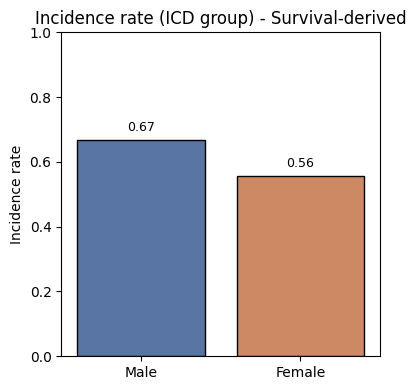

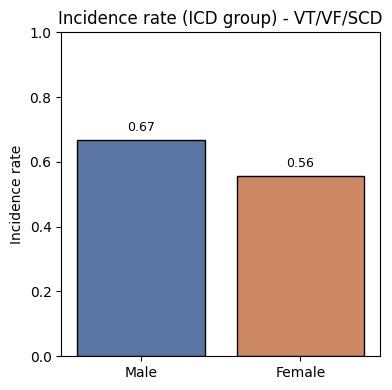


===== No-ICD group =====
- Samples: total=85, with_survival_label=85
- Using survival/master-derived labels:
  Acc=0.718, AUC=0.503, F1=0.077, Sens=0.048, Spec=0.938
  Male: Acc=0.732, AUC=0.539, F1=0.000, Sens=0.000, Spec=0.953
  Female: Acc=0.690, AUC=0.423, F1=0.182, Sens=0.125, Spec=0.905
  Incidence (M/F) = (6.500/2.667)
- Using VT/VF/SCD labels:
  Acc=0.929, AUC=0.786, F1=0.000, Sens=0.000, Spec=0.940
  Male: Acc=0.946, AUC=0.782, F1=0.000, Sens=0.000, Spec=0.964
  Female: Acc=0.897, AUC=nan, F1=0.000, Sens=nan, Spec=0.897
  Incidence (M/F) = (0.500/0.000)


/tmp/ipykernel_3978179/2507202842.py:293: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


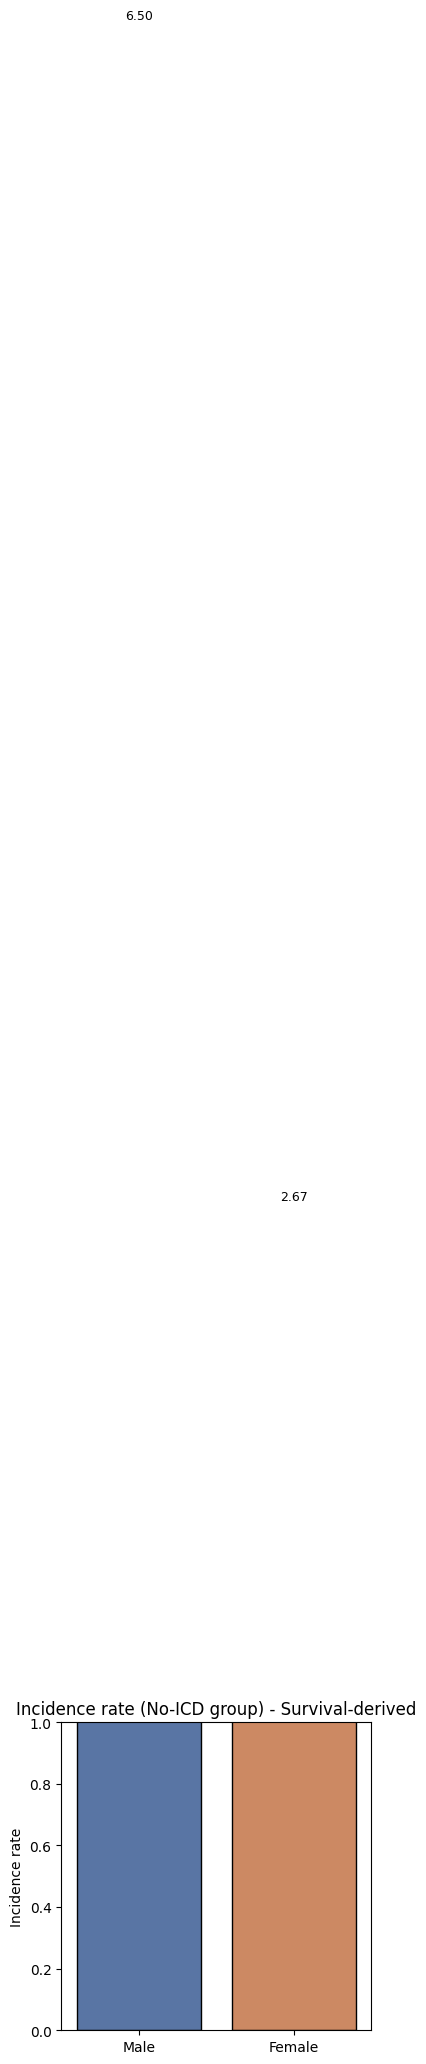

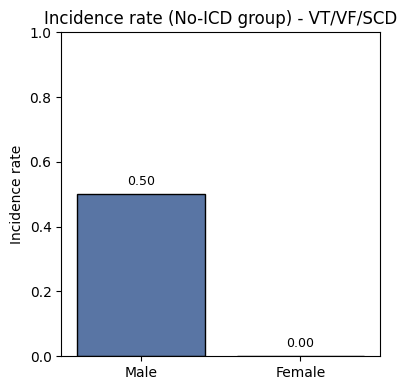

In [ ]:
features = [
        "Female",
        "Age by decade",
        "BMI",
        "AF",
        "Beta Blocker",
        "CrCl>45",
        "LVEF",
        "QTc",
        "NYHA>2",
        "CRT",
        "AAD",
        "Significant LGE",
    ]

metrics, rates, merged = run_full_train_sex_specific_inference(
    train_df, test_df, survival_df,
    id_col="MRN",
    icd_indicator_col="ICD",
    appropriate_icd_shock_col="Was Primary Endpoint Reached? (Appropriate ICD Therapy)",
    death_col="Was Secondary Endpoint Reached?",
    features=features,
    master_df=master_spreadsheet,
    master_label_col="Composite Outcome",
    master_id_col="MRN",
)

grouped, merged = sex_specific_train_and_grouped_eval(
    train_df, test_df, survival_df,
    id_col="MRN",
    icd_indicator_col="ICD",
    appropriate_icd_shock_col="Was Primary Endpoint Reached? (Appropriate ICD Therapy)",
    death_col="Death",
    features=features,
    master_df=master_spreadsheet,
    master_label_col="Composite Outcome",
    master_id_col="MRN",
)

### Model (2)

Training Male Model...
Best hyperparameters: {'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 249}
Training Female Model...
Best hyperparameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 136}


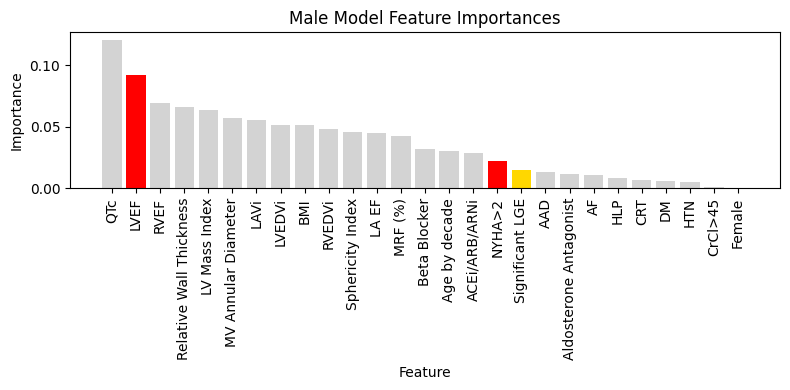

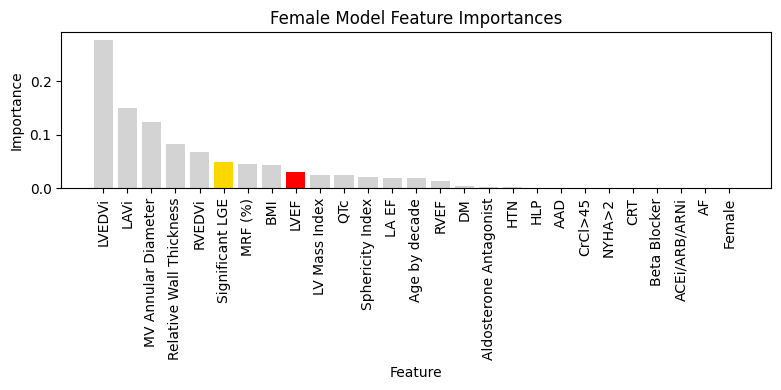


=== Risk Group Analysis by ICD Status ===

--- ICD Group Analysis (n=73) ---
Endpoint: Appropriate ICD Therapy
Low Risk Group (n=28): 4 events, Incidence Rate: 0.1429
High Risk Group (n=45): 9 events, Incidence Rate: 0.2000
Chi-square test p-value: 0.75964
Risk Ratio (High/Low): 1.400

=== Overall Summary ===
Total test samples: 158
ICD group: 73
No-ICD group: 0

Risk Group Distribution:
  Low Risk: 28
  High Risk: 45

Male Clustering Analysis:
Selected best number of clusters for Male using elbow method: 2
Average risk per cluster (Male):
0    0.245
1    0.100
dtype: float64

Female Clustering Analysis:
Selected best number of clusters for Female using elbow method: 2
Average risk per cluster (Female):
0    0.158
1    0.351
dtype: float64

Performing Bootstrap Evaluation...

Bootstrap Results:
Male Acc: 0.8953 [95% CI: 0.8658 - 0.9218]
Male Auc: 1.0000 [95% CI: 1.0000 - 1.0000]
Male F1: 0.6576 [95% CI: 0.5619 - 0.7433]
Male En: 1.0000 [95% CI: 1.0000 - 1.0000]
Male Pec: 0.8835 [95% C

In [14]:
features = [
    "Female",
    "Age by decade",
    "BMI",
    "AF",
    "Beta Blocker",
    "CrCl>45",
    "LVEF",
    "QTc",
    "NYHA>2",
    "CRT",
    "AAD",
    "Significant LGE",
    "DM",
    "HTN",
    "HLP",
    "LVEDVi",
    "LV Mass Index",
    "RVEDVi",
    "RVEF",
    "LA EF",
    "LAVi",
    "MRF (%)",
    "Sphericity Index",
    "Relative Wall Thickness",
    "MV Annular Diameter",
    "ACEi/ARB/ARNi",
    "Aldosterone Antagonist",
]
full_model_inference(
    train_df,
    test_df,
    features,
    "VT/VF/SCD",
    survival_df,
    seed=0,
)

### Model (3)

Training Male Model...
Best hyperparameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 351}
Training Female Model...
Best hyperparameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 231}


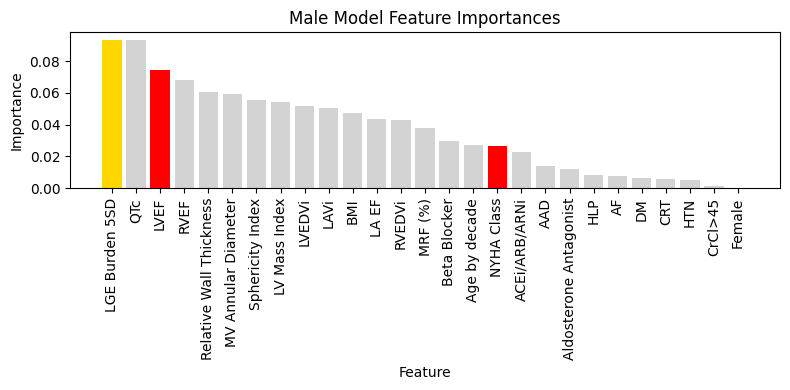

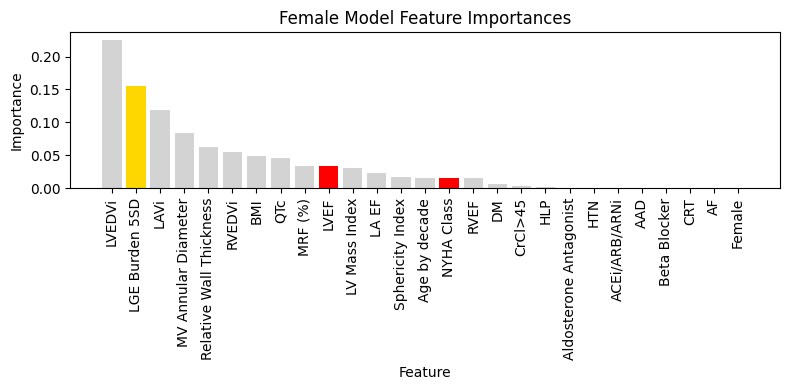


=== Risk Group Analysis by ICD Status ===

--- ICD Group Analysis (n=73) ---
Endpoint: Appropriate ICD Therapy
Low Risk Group (n=36): 6 events, Incidence Rate: 0.1667
High Risk Group (n=37): 7 events, Incidence Rate: 0.1892
Chi-square test p-value: 1.00000
Risk Ratio (High/Low): 1.135

=== Overall Summary ===
Total test samples: 158
ICD group: 73
No-ICD group: 0

Risk Group Distribution:
  Low Risk: 36
  High Risk: 37

Male Clustering Analysis:
Selected best number of clusters for Male using elbow method: 2
Average risk per cluster (Male):
0    0.170
1    0.071
dtype: float64

Female Clustering Analysis:
Selected best number of clusters for Female using elbow method: 2
Average risk per cluster (Female):
0    0.084
1    0.179
dtype: float64

Performing Bootstrap Evaluation...

Bootstrap Results:
Male Acc: 0.9836 [95% CI: 0.9726 - 0.9948]
Male Auc: 1.0000 [95% CI: 1.0000 - 1.0000]
Male F1: 0.9243 [95% CI: 0.8628 - 0.9747]
Male En: 1.0000 [95% CI: 1.0000 - 1.0000]
Male Pec: 0.9817 [95% C

In [11]:
features = [
    "Female",
    "Age by decade",
    "BMI",
    "AF",
    "Beta Blocker",
    "CrCl>45",
    "LVEF",
    "QTc",
    "NYHA Class",
    "CRT",
    "AAD",
    "LGE Burden 5SD",
    "DM",
    "HTN",
    "HLP",
    "LVEDVi",
    "LV Mass Index",
    "RVEDVi",
    "RVEF",
    "LA EF",
    "LAVi",
    "MRF (%)",
    "Sphericity Index",
    "Relative Wall Thickness",
    "MV Annular Diameter",
    "ACEi/ARB/ARNi",
    "Aldosterone Antagonist",
]
full_model_inference(
    train_df,
    test_df,
    features,
    "VT/VF/SCD",
    survival_df,
    seed=0,
)